# Imports

In [41]:
import cv2
import numpy as np
import scipy.ndimage as rt
from matplotlib import pyplot as plt
import shutil
import os
import string
import random

# Pre-requisites

In [42]:

if os.path.exists('Line_Segment'):
    shutil.rmtree('Line_Segment')
if os.path.exists('Char_Segment'):
    shutil.rmtree('Char_Segment')

In [43]:
img_global = "D:/test/SharadaScripture-OCR/test/inclined_3.jpg"
img = cv2.imread(img_global)

## Skew Correction

In [44]:
def correct_skew(image, delta=1, limit=5):
    def determine_score(arr, angle):
        data = rt.rotate(arr, angle, reshape=False, order=0)
        histogram = np.sum(data, axis=1, dtype=float)
        score = np.sum((histogram[1:] - histogram[:-1]) ** 2, dtype=float)
        return histogram, score

    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1] 

    scores = []
    angles = np.arange(-limit, limit + delta, delta)
    for angle in angles:
        histogram, score = determine_score(thresh, angle)
        scores.append(score)

    best_angle = angles[scores.index(max(scores))]

    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, best_angle, 1.0)
    corrected = cv2.warpAffine(image, M, (w, h), flags=cv2.INTER_CUBIC, \
            borderMode=cv2.BORDER_REPLICATE)

    return best_angle, corrected

In [45]:
angle, corrected = correct_skew(img)
print(angle)

-4


# Line Segmentation

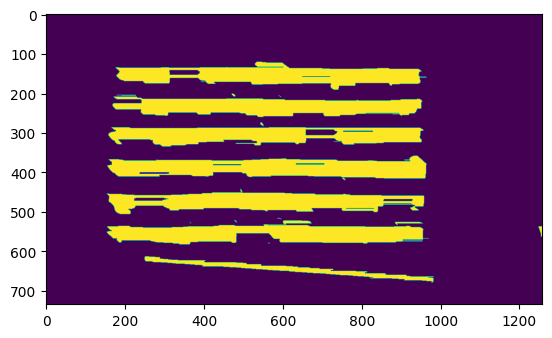

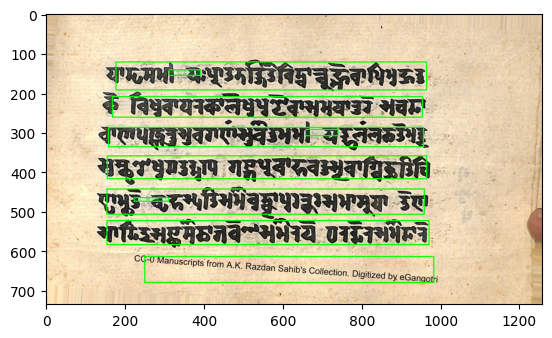

In [46]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

img = corrected

dnc = cv2.fastNlMeansDenoisingColored(img, None, 10, 10, 7, 15) 

# Convert the image to grayscale
gray = cv2.cvtColor(dnc, cv2.COLOR_BGR2GRAY)

ret, img_bin = cv2.threshold(gray, 120, 255, cv2.THRESH_BINARY_INV, cv2.THRESH_OTSU) # imgf contains Binary image

# Defining a kernel length
kernel_len = np.array(img).shape[1]//150

# Defining a horizontal kernel for horizontal dilation
hor_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (kernel_len, 1))

# Use horizontal kernel to connect text characters and remove spaces
horizontal_lines = cv2.dilate(img_bin, hor_kernel, iterations=5)

# Now we erode
horizontal_lines = cv2.erode(horizontal_lines, hor_kernel, iterations=10)

plt.imshow(horizontal_lines)
plt.show()

# Find contours for image, which will detect all lines
contours, _ = cv2.findContours(horizontal_lines, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

# Sort all the contours by top to bottom.
contours = sorted(contours, key=lambda ctr: cv2.boundingRect(ctr)[1])

# Calculate mean contour area
mean_area = np.mean([cv2.contourArea(ctr) for ctr in contours])

# Loop over the contours
for contour in contours:
    # Skip small contours
    if cv2.contourArea(contour) < mean_area / (np.array(img).shape[1]//100):
        continue
    # Get bounding box
    x, y, w, h = cv2.boundingRect(contour)
    # Draw the bounding box
    cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)

# Display the image
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()


In [47]:
import cv2
cv2.imshow("img",img)
cv2.waitKey(0)

-1